Notebook for plotting ripple features during natural sleep.

#### NRK TODO: update for eeg file with multiple electrodes

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    plot_dir = Path("/Users/nkinsky/University of Michigan Dropbox/Nathaniel Kinsky/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots")
    # assert False, 'plot_dir not yet implemented on Nat laptop'
elif platform.system() == "Linux":
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots')
    if environ["HOSTNAME"] == "lnx00035":
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy/'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.core.neurons import Neurons
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO
from neuropy.plotting.signals import plot_signal_traces
from neuropy.plotting.spikes import plot_raster

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
if platform.system() == "Darwin": # Nat laptop
    dir_use = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/Clustering/sessions/RatU/RatUDay2NSD")
    nchan_eeg = 1
    chan_use_rip = np.array([0])
    eeg_glob_str = "*thetachan.eeg"
elif platform.system() == "Linux":
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        # dir_use = None
        # assert False,  "No data on Nat linux computer"
        dir_use = Path("/data/Clustering/sessions/RatU/RatUDay2NSD/")
        nchan_eeg = 6
        chan_use_rip = np.arange(6)
        eeg_glob_str = "*08-16-38.swr_shank.eeg"
    if environ["HOSTNAME"] == "lnx00035":
        dir_use = Path("/data/Clustering/sessions/RatU/RatUDay2NSD/")
        nchan_eeg = 192
        chan_use_rip = np.arange(112, 127, 3)
        eeg_glob_str = "*08-16-38.eeg"

In [3]:
from neuropy.core.session import ProcessData

eegfile = BinarysignalIO(sorted(dir_use.glob(eeg_glob_str))[0], n_channels=nchan_eeg, sampling_rate=1250)
signal = eegfile.get_signal()

neurons = Neurons.load(sorted(dir_use.glob("*.neurons.stable.npy"))[0]).get_neuron_type("pyr")

ripple_epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.ripple.npy"))[0])
ripple_epochs

rec_epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.paradigm.npy"))[0])
rec_epochs

4 epochs
Snippet: 
    start   stop    label
0      0   9544      pre
1   9545  12855     maze
2  12856  45316     post
3  45317  48496  re-maze

In [4]:
from neuropy.analyses.oscillations import Ripple
id = 103
buffer = 0.25
rip_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])

mean_swr_wvlt = Ripple.get_mean_wavelet(eegfile, chan_use_rip[0], rip_use)

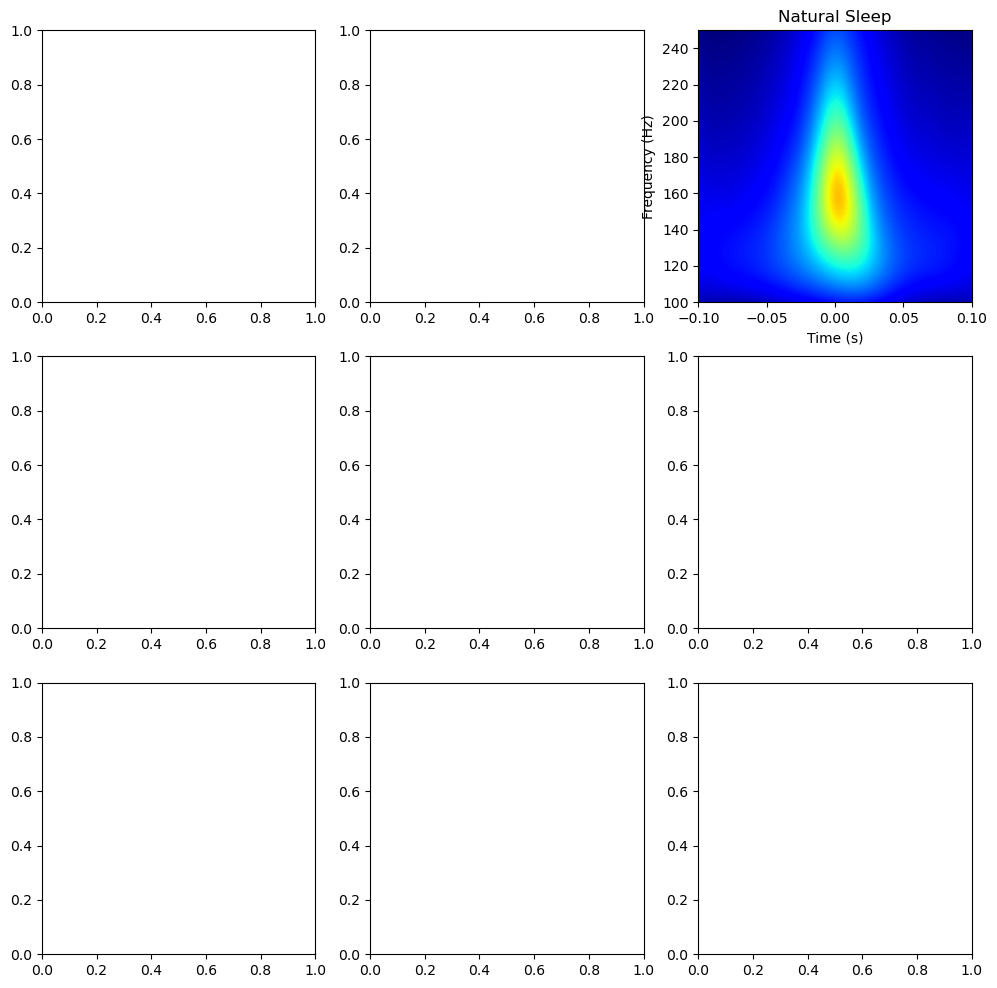

In [5]:
from neuropy.plotting.signals import plot_spectrogram
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
plot_spectrogram(mean_swr_wvlt.traces, time_lims=(-0.1, 0.1), freq_lims=(100, 250), widget=False, ax=ax[0][2])
ax[0][2].set_title("Natural Sleep")
# _, ax = plt.subplots()
# # sns.heatmap(mean_swr_wvlt.traces, cmap="jet", widget=False, freqax=ax)
fig.savefig(plot_dir / "NSD_wavelet_mean.pdf")

interactive(children=(IntSlider(value=106, description='SWR #', max=3000), Output()), _dom_classes=('widget-in…

<function __main__.plot_swr_w_pbe(id, axeeg, axspike)>

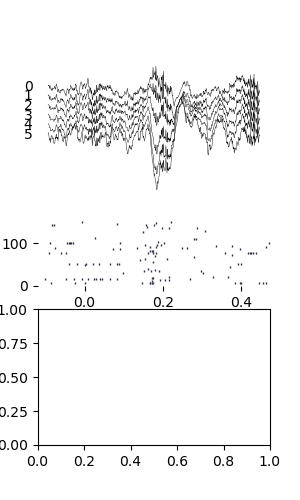

In [6]:
%matplotlib widget
import ipywidgets as widgets
buffer = 0.25
def plot_swr_w_pbe(id, axeeg, axspike):
    axeeg.clear()
    axspike.clear()
    plot_signal_traces(signal.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer,
                                     channel_id=chan_use_rip), ax=axeeg, lw=0.3)
    plot_raster(neurons.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer), ax=axspike)
    # plot_signal_traces(signal.time_slice(t_start=rip_use.to_dataframe().peak_time[id] - buffer, 
    #                                      t_stop=rip_use.to_dataframe().peak_time[id] + buffer,
    #                                      channel_id=chan_use_rip), 
    #                    ax=axeeg, lw=0.3)
    # plot_raster(neurons.time_slice(t_start=rip_use.to_dataframe().peak_time[id] - buffer, 
    #                                t_stop=rip_use.to_dataframe().peak_time[id] + buffer), 
                # ax=axspike)


fig, ax = plt.subplots(3, 1, figsize=(3, 5), height_ratios=[4, 2, 4])
for a in ax[0:2]:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("")
    a.set_ylabel("")
    sns.despine(ax=a, left=True, bottom=True)


widgets.interact(plot_swr_w_pbe,
                 id=widgets.IntSlider(min=0, max=3000, value=106, step=1, description="SWR #"),
                 axeeg=widgets.fixed(ax[0]),
                 axspike=widgets.fixed(ax[1]))

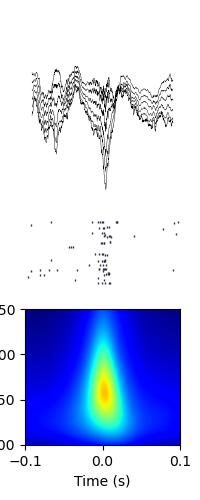

In [7]:
from neuropy.plotting.signals import plot_signal_traces
from neuropy.plotting.spikes import plot_raster

fig, ax = plt.subplots(3, 1, figsize=(2, 5), height_ratios=[4, 2, 4])

id = 2845  # 106 is good but has out-of-ripple firing
buffer = 0.35
rip_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])
plot_signal_traces(signal.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer,
                                     channel_id=chan_use_rip), ax=ax[0], lw=0.3)

plot_raster(neurons.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer), ax=ax[1])

plot_spectrogram(mean_swr_wvlt.traces, time_lims=(-0.1, 0.1), freq_lims=(100, 250), widget=False, ax=ax[2])

for a in ax[0:2]:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("")
    a.set_ylabel("")
    sns.despine(ax=a, left=True, bottom=True)

fig.savefig(plot_dir / "NSD_SWR_w_PBE.pdf")

### Plot histograms of ripple features

iso Ripple rate = 0.510 Hz
iso Total ripple duration / recording time = 0.0627


,rpl_rate,rpl_time_prop,session
0,0.51016,0.062727,iso


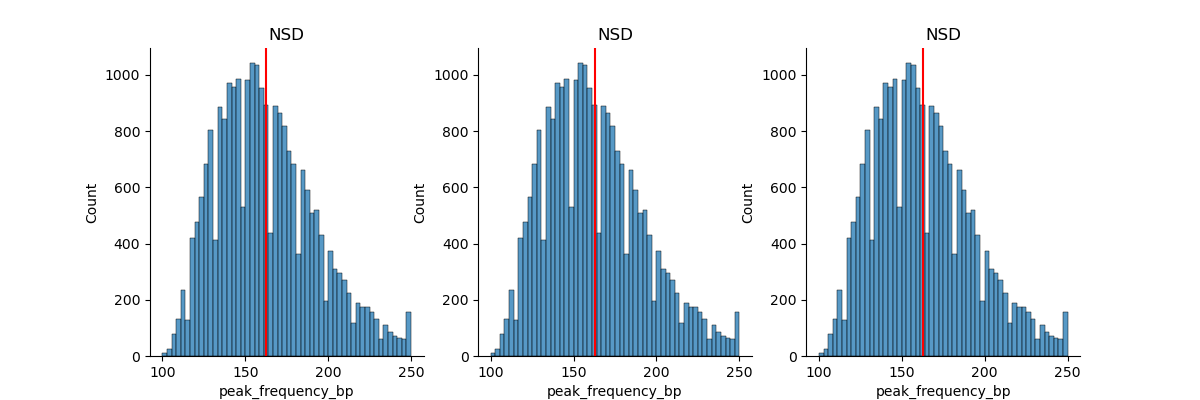

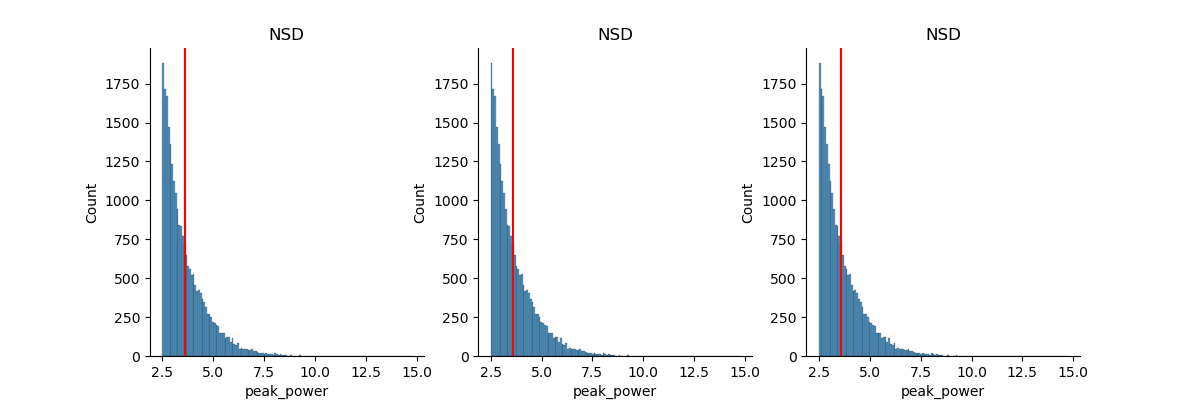

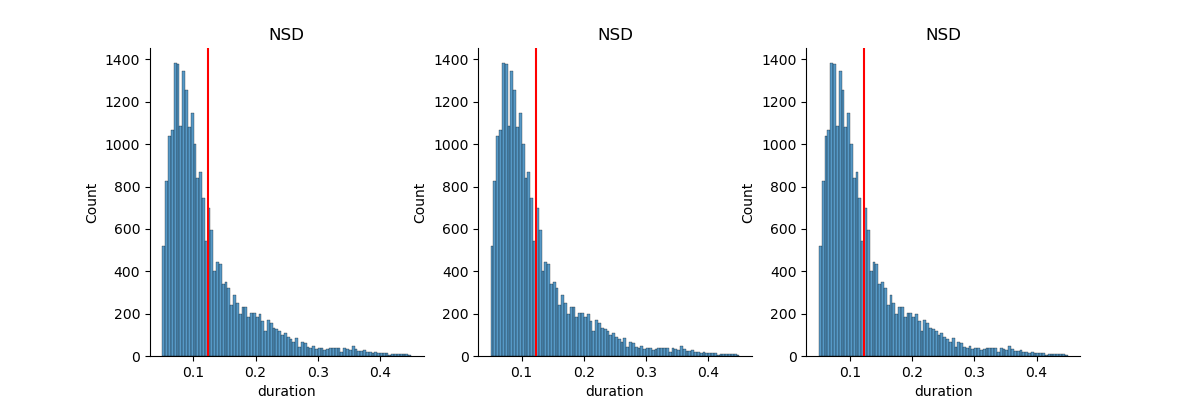

In [21]:
dur_thresh = 0
for metric in ["peak_frequency_bp", "peak_power", "duration"]:
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    for a, sname in zip(ax, ["propofol", "DEX", "iso"]):
        rip_df = ripple_epochs.to_dataframe()
        rip_df = rip_df[rip_df.duration > dur_thresh]

        sns.histplot(data=rip_df, x=metric, ax=a)
        a.axvline(rip_df[metric].mean(), color='r')
        a.set_title("NSD")
        sns.despine(ax=a)

rpl_rate_df = []
rpl_rate = rip_df.shape[0] / eegfile.duration
rpl_time_per_sec = rip_df["duration"].values.sum() / eegfile.duration
rpl_rate_df.append(pd.DataFrame({"rpl_rate": rpl_rate, "rpl_time_prop": rpl_time_per_sec, "session": sname}, index=[0]))
print(f"{sname} Ripple rate = {rpl_rate:.3f} Hz")
print(f"{sname} Total ripple duration / recording time = {rpl_time_per_sec:0.4f}")
rpl_rate_df = pd.concat(rpl_rate_df, axis=0, ignore_index=True)
rpl_rate_df

### Plot PBEs

In [11]:
fr_array_test, times = binned_pe_raster(mua, ripple_epochs_use.to_dataframe().peak_time.values, buffer_sec=(0.2, 0.2))

In [24]:
from neuropy.core.neurons import binned_pe_raster
smooth_mua=False
buffer_sec = (0.2, 0.2)
if not smooth_mua:
    mua = neurons.get_mua(bin_size=0.01)
elif smooth_mua:
    mua = neurons.get_mua(bin_size=0.001).get_smoothed(sigma=0.02)
ripple_epochs_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].starts[0] + 600)
# fr_array = binned_pe_raster(mua, ripple_epochs_use.to_dataframe()["peak_time"].values, buffer_sec=buffer_sec, neuron_id=0)

In [25]:
ripple_epochs_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])
rpl_peak_frames2 = ((ripple_epochs_use.to_dataframe().peak_time.values - mua.t_start) / mua.bin_size).astype(int)
buffer_frames2 = (np.array(buffer_sec) / mua.bin_size).astype(int)
temp = 0
temp2 = []
mua_fr = mua.firing_rate
for peak_frame in rpl_peak_frames2:
    # start_stop = np.digitize([peak_time - buffer_sec[0], peak_time + buffer_sec[1]], mua.time)
    # inds.append(np.arange(start_stop[0], start_stop[1] + 1))
    # temp += mua.firing_rate[(peak_frame - buffer_frames2[0]):(peak_frame + buffer_frames2[1] + 1)]
    temp += mua_fr[(peak_frame - buffer_frames2[0]):(peak_frame + buffer_frames2[1] + 1)]
    temp2.append(mua_fr[(peak_frame - buffer_frames2[0]):(peak_frame + buffer_frames2[1] + 1)])

    

### Plan: try normalizing to overall firing rates of MUA, could be very small mean and std for sedation though, which could give very large z scores!  If so, normalize using mean and std from MAZE, not from sedation periods.

In [34]:
fr_array

array([[  0.,   0.,   0., ...,   0., 200.,   0.],
       [100., 600.,   0., ..., 300., 300., 200.],
       [100., 300., 100., ...,   0., 200., 100.],
       ...,
       [300., 100., 400., ...,   0.,   0.,   0.],
       [100.,   0.,   0., ...,   0.,   0.,   0.],
       [400., 100.,   0., ..., 100., 100., 100.]])

In [33]:
fr_array / fr_array.max(axis=1)[:, None]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.09090909, 0.54545455, 0.        , ..., 0.27272727, 0.27272727,
        0.18181818],
       [0.11111111, 0.33333333, 0.11111111, ..., 0.        , 0.22222222,
        0.11111111],
       ...,
       [0.375     , 0.125     , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.125     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.25      , 0.        , ..., 0.25      , 0.25      ,
        0.25      ]])

In [19]:
mua_mean = mua.firing_rate.mean()
mua_std = mua.firing_rate.std()

<Axes: >

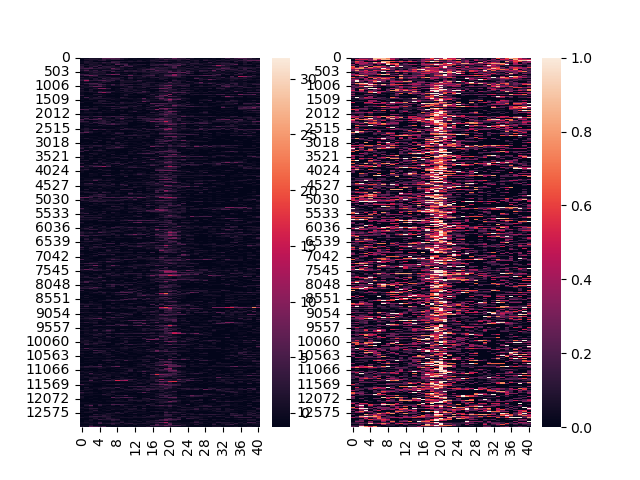

In [35]:
_, ax = plt.subplots(1, 2)
sns.heatmap((fr_array - mua_mean) / mua_std, ax=ax[0])
sns.heatmap(fr_array / fr_array.max(axis=1)[:, None], ax=ax[1])

In [41]:
# Get probability each cell is active during a ripple

# neurons = neurons.get_neuron_type([1, 2, 3])
binned_spiketrains = neurons.get_binned_spiketrains(bin_size=0.005)
rasters = []
buffer_sec = (0.2, 0.2)
for neuron_id in binned_spiketrains.neuron_ids:
    fr_array_use, pe_times = binned_pe_raster(binned_spiketrains, event_times=ripple_epochs.to_dataframe()["peak_time"].values, 
                                                           neuron_id=neuron_id, buffer_sec=buffer_sec)
    rasters.append(fr_array_use)
    
# spikes_in_ripples, _ = neurons.get_spikes_in_epochs(sess.ripple_epochs)

Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete start/end event from input
Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete start/end event from input
Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete start/end event from input
Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete start/end event from input
Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete start/end event from input
Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete start/end event from input
Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete start/end event from input
Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete start/end event from input
Raster has uneven # of bins in one row, likely due to edge effects. Fix code or delete s

In [ ]:
prop_active_array = (np.stack(rasters, axis=2) > 0).mean(axis=2)

ax = axs[0][0]
axc = axs[0][1]
sns.heatmap(prop_active_array, ax=ax, cbar_ax=axc)
ax.set_title("Proportion cells active")
ax.set_xlabel("Time from ripple peak (s)")
ax.set_yticks([0, sess.ripple_epochs.n_epochs])
ax.set_ylabel("Ripple #")
ax.set_xticks([0, int(len(pe_times)/2), len(pe_times)])
ax.set_xticklabels([pe_times[0], 0, -pe_times[0]])

ax = axs[1][0]
prop_mean, prop_std = np.mean(prop_active_array, axis=0), np.std(prop_active_array, axis=0)
ax.plot(pe_times, prop_mean, 'k-')
ax.fill_between(pe_times, prop_mean - prop_std, prop_mean + prop_std, color=[0, 0, 0, 0.2])
ax.set_ylabel("Mean prop. active")
ax.set_xlabel("Time from ripple peak (s)")
ax.set_xlim([-buffer_sec[0], buffer_sec[1]])
sns.despine(fig=fig)

In [29]:
fr_array.shape

(13077, 41)

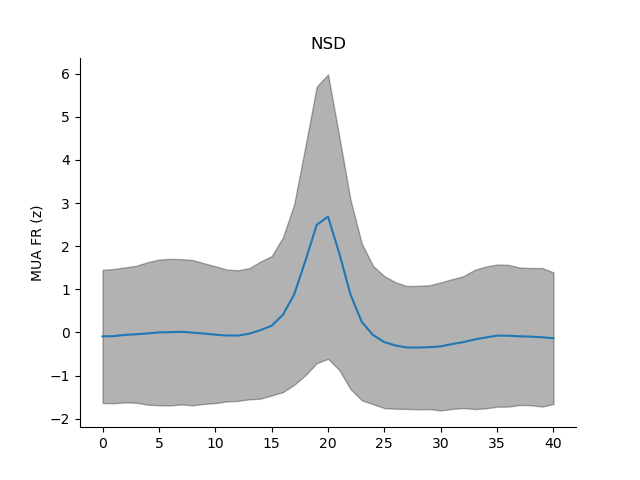

In [27]:
fig, ax = plt.subplots()
fr_array = np.array(temp2)
fr_z = (fr_array.mean(axis=0) - mua_mean) / mua_std
ax.plot(fr_z )
ax.fill_between(np.arange(fr_z.shape[0]), 
                fr_z - fr_array.std(axis=0) / mua_std, 
                fr_z + fr_array.std(axis=0) / mua_std, 
                color=[0, 0, 0, 0.3])

ax.set_ylabel("MUA FR (z)")
ax.set_title("NSD")
sns.despine(ax=ax)

smooth_flag = "_smoothed" if smooth_mua else "_unsmoothed"
fig.savefig(plot_dir / f"NSD_periSWR_PBE_rate{smooth_flag}.pdf")

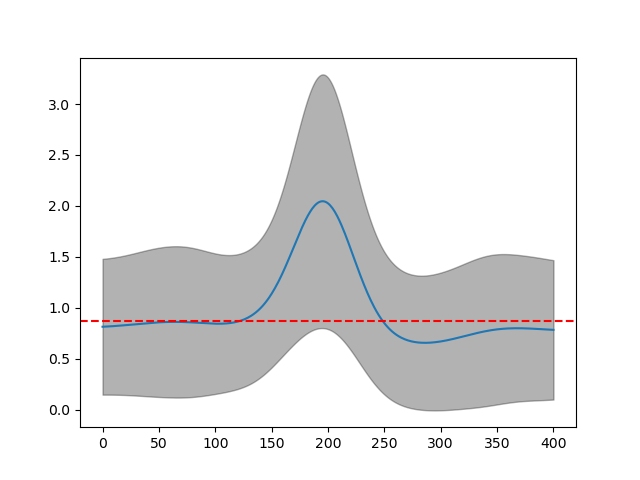

In [17]:
_, ax = plt.subplots()
ax.plot(np.array(temp2).mean(axis=0) / neurons.n_neurons)
ax.fill_between(np.arange(temp2[0].shape[0]), 
                (np.array(temp2).mean(axis=0) - np.array(temp2).std(axis=0)) / neurons.n_neurons,
                (np.array(temp2).mean(axis=0) + np.array(temp2).std(axis=0)) / neurons.n_neurons,
                color=[0, 0, 0, 0.3])
ax.axhline(mua.firing_rate.mean() / neurons.n_neurons, color='r', linestyle='--')

In [ ]:
fr_array_test = 0
for rpl_peak in rpl_peak_frames:
    # fr_array_test.append(mua.firing_rate[(rpl_peak - buffer_frames[0]):(rpl_peak + buffer_frames[1] + 1)])
    fr_array_test += mua.firing_rate[(rpl_peak - buffer_frames[0]):(rpl_peak + buffer_frames[1] + 1)]
fr_array_test


In [ ]:
fr_array[0].mean(axis=0)

In [ ]:
ripple_epochs_use

In [ ]:
rpl_peak

In [ ]:
np.mean(fr_array, axis=0)

In [ ]:
ripple_epochs.n_epochs

In [ ]:
ripple_epochs_use

In [ ]:
fr_array[0].shape

In [ ]:
%matplotlib widget
norm_by_n_neurons = True
buffer_sec = (0.2, 0.2)
from neuropy.plotting.spikes import plot_mua, plot_raster, plot_binned_raster

for smooth_mua in [False, True]:
    fig, axall = plt.subplots(2, 3, height_ratios=[5, 1], figsize=(12, 5), sharex=False)
    fig.suptitle(f"MUA smooth = {smooth_mua}")
    axs = axall[:, 0]

    if not smooth_mua:
        mua = neurons.get_mua(bin_size=0.01)
    elif smooth_mua:
        mua = neurons.get_mua(bin_size=0.001).get_smoothed(sigma=0.02)
    # plot_mua(sess.mua)

    # ripple_epochs_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])
    ripple_epochs_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].starts[0] + 600)
    
    ax, fr_array, pe_times = plot_binned_raster(mua, ripple_epochs_use.to_dataframe()["peak_time"].values, buffer_sec=buffer_sec, 
                                                ax=axs[0], cbar=None)
    
    axs[0].set_title("NSD")

    fr_mean, fr_std = np.nanmean(fr_array, axis=0), np.nanstd(fr_array, axis=0)
    fr_norm = neurons.n_neurons if norm_by_n_neurons else 1
    axs[1].plot(pe_times, fr_mean / fr_norm, 'k-')
    axs[1].fill_between(pe_times, (fr_mean - fr_std) / fr_norm, (fr_mean + fr_std) / fr_norm, color=[0, 0, 0, 0.3])
    axs[1].set_xlabel("Time from ripple peak")

    sns.despine(fig=fig)